In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from Backtesting import stats, portfolio

In [2]:
def signal_generation(asset, period, delta, multiplier, beta, exit):

    signals = pd.DataFrame()
    signals['asset'] = asset['Close']
    signals['rsi'] = 0.0

    signals['std'] = signals["asset"].rolling(window=20, min_periods=20).std()
    signals['signals'] = 0
    signals['positions'] = 0
    signals['coordinates'] = ''

    # Default RSI calculation window
    rsi_window = 14

    pos = pd.Series([i if i > 0 else 0 for i in signals['asset'].diff().dropna()]).rolling(rsi_window).mean()
    neg = pd.Series([-i if i < 0 else 0 for i in signals['asset'].diff().dropna()]).rolling(rsi_window).mean()
    signals['rsi'] = np.concatenate([[50.0] * rsi_window, (100-100/(1 + np.divide(pos, neg)[rsi_window - 1:]))])

    entry = 0.0
    
    # Head and shoulders pattern recognition
    for g in range(period + 14, len(signals)):
        pattern_found=False
        
        # Bottom right
        if signals['positions'].iloc[g] == 0 and signals['asset'].iloc[g] != max(signals['asset'].iloc[g-period:g]):
            d = signals.index.get_loc(signals['asset'].iloc[g-period:g].idxmax())
            
            # Head
            if np.abs(signals['asset'].iloc[d]-signals['asset'].iloc[g]) > multiplier * delta:
                for e in range(d, g):

                    # Mid right
                    if np.abs(signals['asset'].iloc[e]-signals['asset'].iloc[g]) < delta:
                        for c in range(d, g-period, -1):

                            # Mid left
                            if np.abs(signals['asset'].iloc[c] - signals['asset'].iloc[g]) < delta:
                                for a in range(g-period, c):

                                    # Bottom left
                                    if np.abs(signals['asset'].iloc[a] - signals['asset'].iloc[g]) < delta:
                                        b = signals.index.get_loc(signals['asset'].iloc[a:c].idxmax())

                                        # Left shoulder
                                        if signals['asset'].iloc[b] - signals['asset'].iloc[g] > multiplier * delta and signals['asset'].iloc[d] - signals['asset'].iloc[b] > multiplier * delta:
                                            for f in range(e, g):
                                                
                                                # Right shoulder
                                                if np.abs(signals['asset'].iloc[f] - signals['asset'].iloc[b]) < delta:
                                                    signals.at[signals.index[g],'signals'] = -1
                                                    signals.at[signals.index[g],'coordinates'] = f'{a},{b},{c},{d},{e},{f},{g}'
                                                    signals['positions'] = signals['signals'].cumsum()
                                                    entry = signals['rsi'].iloc[g]
                                                    pattern_found = True
                                                    break
                                        break
                                break
                        break

        # Exit position based on RSI and expansion/contraction trigger
        if signals['positions'].iloc[g] != 0 and not pattern_found and (signals['std'].iloc[g] > beta or signals['rsi'].iloc[g] - entry > exit):
            signals.at[signals.index[g],'signals'] = 1
            entry = 0.0
            signals['positions'] = signals['signals'].cumsum()
            
    return signals

In [3]:
def plot(signals, ticker):

    # Long/short signals
    plt.figure(figsize=(11,7))
    plt.plot(signals['asset'], label=ticker, color='C0')
    plt.plot(signals['asset'][signals['signals']>0], lw=0, marker='^', markersize=7, c='g', alpha=0.6, label='LONG')
    plt.plot(signals['asset'][signals['signals']<0], lw=0, marker='v', markersize=7, c='r', alpha=0.6, label='SHORT')
    plt.legend(loc='upper left')
    plt.xlabel('Date', labelpad=15)
    plt.ylabel(ticker, labelpad=15)
    plt.title('RSI', pad=15)
    plt.grid(True)
    plt.show()

    # RSI
    plt.figure(figsize=(11,7))
    rsi, = plt.plot(signals['rsi'], c='C0')
    
    for i in signals[signals['signals']!=0].index:
        if signals['coordinates'][i] == '':
            continue
        temp=list(map(int,signals['coordinates'][i].split(',')))
        indexlist=list(map(lambda x:signals.index[x],temp))
        head_shoulder, = plt.plot(signals['rsi'][indexlist], lw=5, alpha=0.6, c='C6')
    oversold = plt.fill_between(signals.index, 0, 30, alpha=0.2, color='C2')
    overbought = plt.fill_between(signals.index, 70, 100, alpha=0.2, color='C3')
    plt.legend([rsi, head_shoulder, oversold, overbought], ['RSI', 'Head & Shoulders Pattern', 'Oversold', 'Overbought'], loc='upper left')    
    plt.title('RSI', pad=15)
    plt.xlabel('Date', labelpad=15)
    plt.ylabel('Value', labelpad=15)
    plt.grid(True)
    plt.show()


In [4]:
def RSI(ticker, start_date, end_date, capital):
    
    asset = yf.download(ticker, start=start_date, end=end_date, progress=False)

    # Default head and shoulder pattern horizon, price delta threshold, head/shoulder multiplier, expansion/contraction trigger, and RSI exit trigger
    signals = signal_generation(asset, 100, 0.2, 1.3, 0.3, 20)
    
    plot(signals, ticker)

    return stats(portfolio(signals, capital, 'RSI'), signals, start_date, end_date, capital)

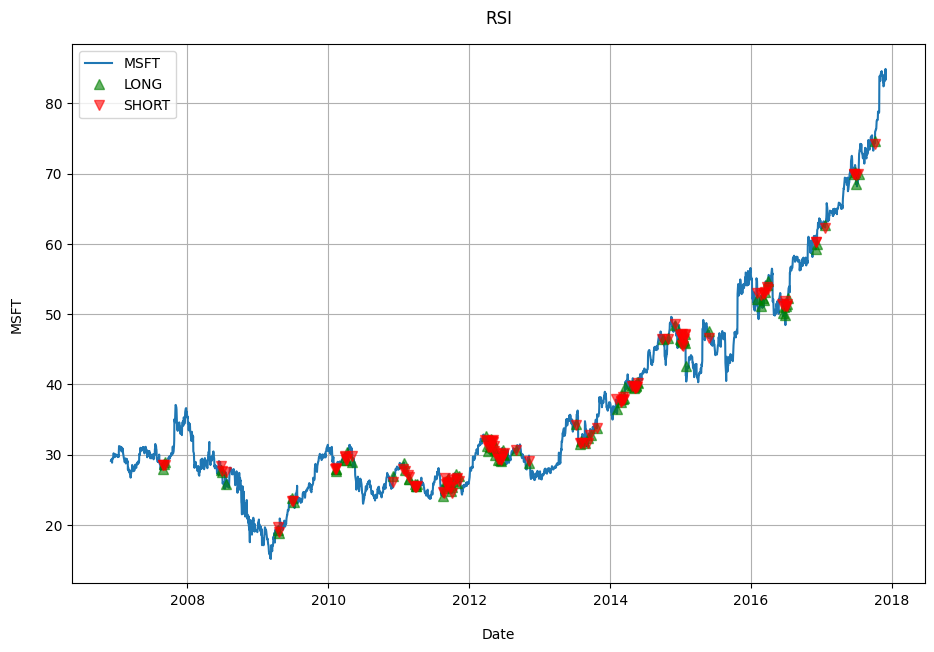

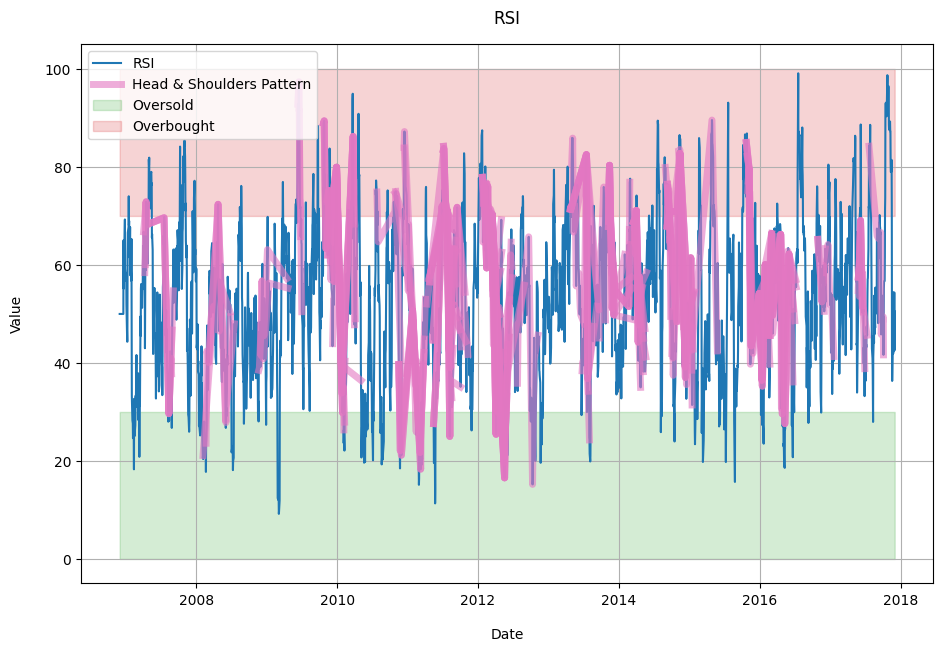

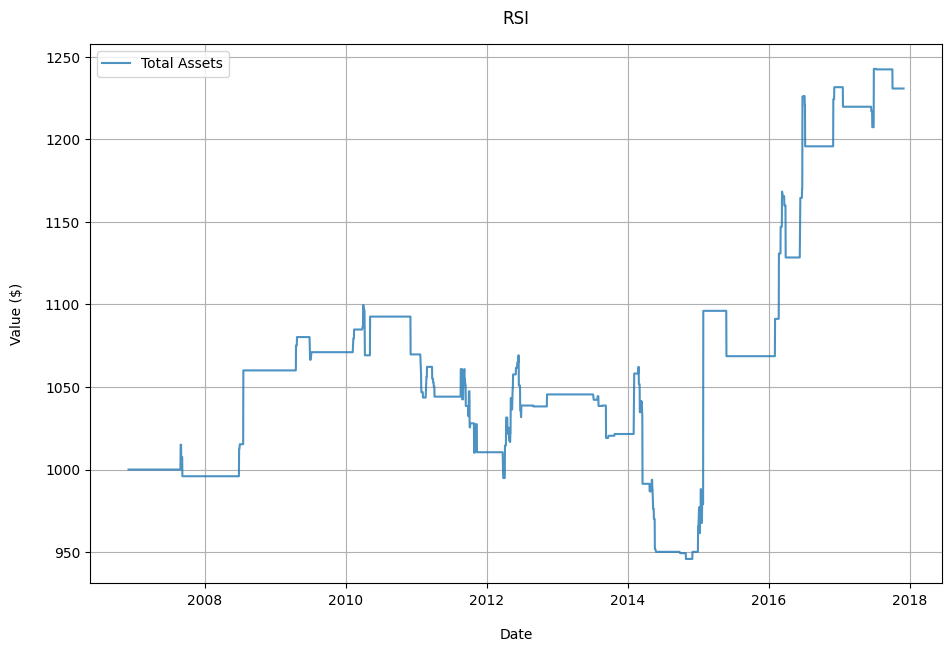

,portfolio return,benchmark return,growth rate,sharpe ratio,maximum drawdown,calmar ratio,avg trade length,profit per trade
0,0.230811,0.890278,0.000075,-0.041085,-0.139848,-0.000536,0.529915,0.986371


In [5]:
RSI('MSFT', '2006-12-01', '2017-12-01', 1000)